In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [4]:
# Load the datasets
current_path = os.getcwd()
file = '\\datasets\\mnist_data\\mnist.pkl.gz'
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [5]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [6]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [7]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [8]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [9]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

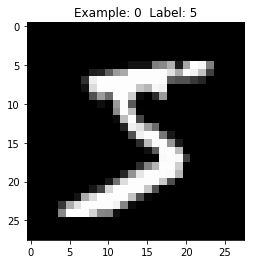

In [10]:
# View the first digit
view_digit(X_train, y_train, 0)

In [11]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [12]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [13]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [14]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [13]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), \
                        range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, \
                        feed_dict={v0: batch, _w: prv_w, \
                                   _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, \
                        feed_dict={v0: batch, _w: prv_w, \
                                   _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, \
                        feed_dict={v0: batch, _w: prv_w, \
                                   _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, \
                                                _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
        
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [14]:
# Since we are training, set input as training data
inputX = np.array(X_train)

# Create list to hold our RBMs
rbm_list = []

# Define the parameters of the RBMs we will train
rbm_list.append(RBM(784,700,1.0,100,200))
rbm_list.append(RBM(700,600,1.0,100,200))
rbm_list.append(RBM(600,500,1.0,100,200))

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17365418261556275987
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4952306483
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6745561158647567863
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [16]:
outputList = []
#For each RBM in our list
for i in range(0,len(rbm_list)):
    print('RBM', i+1)
    #Train a new one
    rbm = rbm_list[i]
    rbm.train(inputX)
    #Return the output layer
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX = hiddenX

RBM 1
Epoch: 0 reconstruction error: 0.076038
Epoch: 1 reconstruction error: 0.064772
Epoch: 2 reconstruction error: 0.059159
Epoch: 3 reconstruction error: 0.054687
Epoch: 4 reconstruction error: 0.052310
Epoch: 5 reconstruction error: 0.050670
Epoch: 6 reconstruction error: 0.048897
Epoch: 7 reconstruction error: 0.047894
Epoch: 8 reconstruction error: 0.046489
Epoch: 9 reconstruction error: 0.045874
Epoch: 10 reconstruction error: 0.045329
Epoch: 11 reconstruction error: 0.044699
Epoch: 12 reconstruction error: 0.043763
Epoch: 13 reconstruction error: 0.044152
Epoch: 14 reconstruction error: 0.043432
Epoch: 15 reconstruction error: 0.043277
Epoch: 16 reconstruction error: 0.042965
Epoch: 17 reconstruction error: 0.042581
Epoch: 18 reconstruction error: 0.042640
Epoch: 19 reconstruction error: 0.042484
Epoch: 20 reconstruction error: 0.042014
Epoch: 21 reconstruction error: 0.041594
Epoch: 22 reconstruction error: 0.041966
Epoch: 23 reconstruction error: 0.041439
Epoch: 24 reconstruc

Epoch: 0 reconstruction error: 0.033035
Epoch: 1 reconstruction error: 0.028154
Epoch: 2 reconstruction error: 0.026225
Epoch: 3 reconstruction error: 0.024834
Epoch: 4 reconstruction error: 0.023869
Epoch: 5 reconstruction error: 0.023291
Epoch: 6 reconstruction error: 0.022722
Epoch: 7 reconstruction error: 0.022056
Epoch: 8 reconstruction error: 0.021738
Epoch: 9 reconstruction error: 0.021673
Epoch: 10 reconstruction error: 0.021240
Epoch: 11 reconstruction error: 0.021207
Epoch: 12 reconstruction error: 0.020967
Epoch: 13 reconstruction error: 0.020717
Epoch: 14 reconstruction error: 0.020482
Epoch: 15 reconstruction error: 0.020249
Epoch: 16 reconstruction error: 0.020182
Epoch: 17 reconstruction error: 0.020047
Epoch: 18 reconstruction error: 0.019977
Epoch: 19 reconstruction error: 0.019647
Epoch: 20 reconstruction error: 0.019690
Epoch: 21 reconstruction error: 0.019645
Epoch: 22 reconstruction error: 0.019475
Epoch: 23 reconstruction error: 0.019409
Epoch: 24 reconstruction e

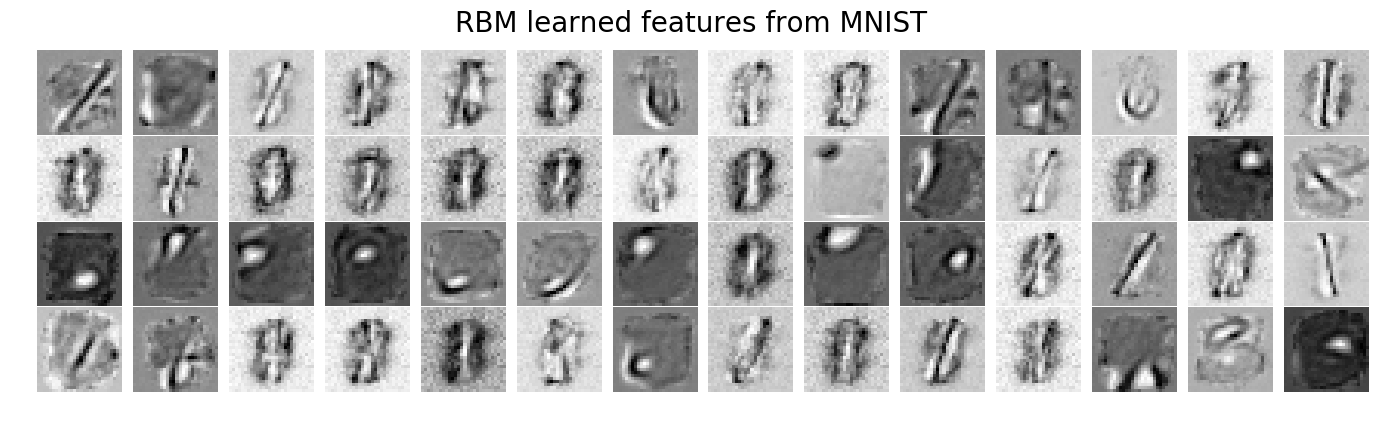

None


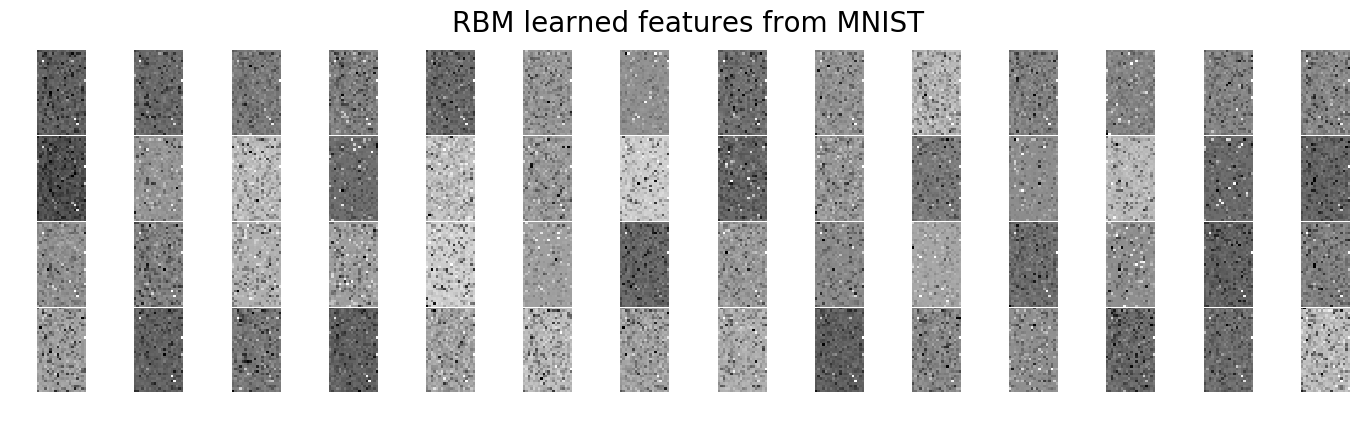

None


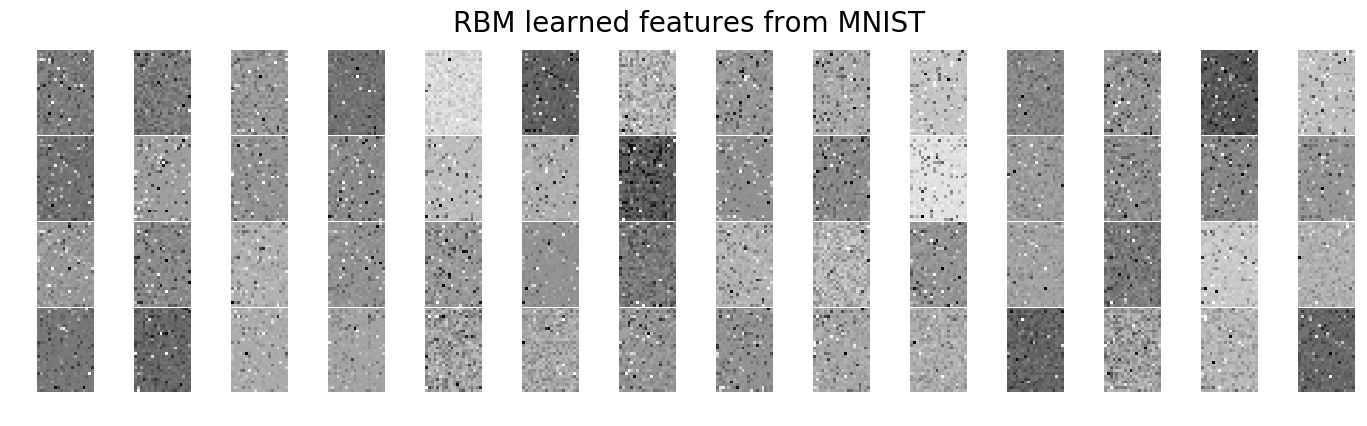

None


In [17]:
rbm_shapes = [(28,28),(35,20),(30,20)]
for i in range(0,len(rbm_list)):
    rbm = rbm_list[i]
    print(rbm.show_features(rbm_shapes[i],"RBM learned features from MNIST", 56))

RBM 1
Image generated by RBM


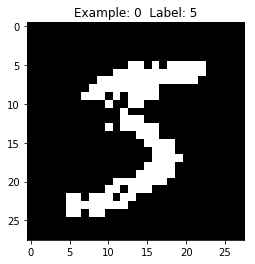

Original image


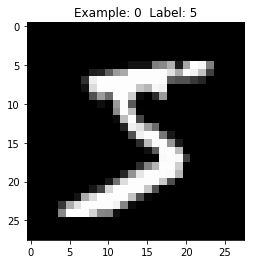

Image generated by RBM


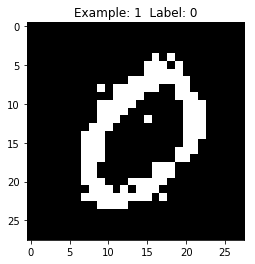

Original image


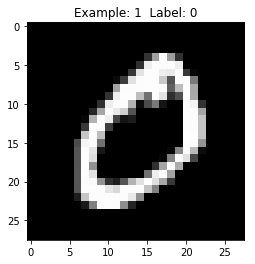

Image generated by RBM


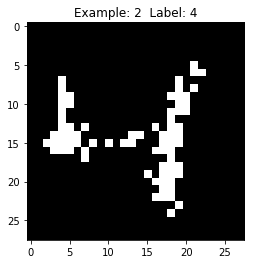

Original image


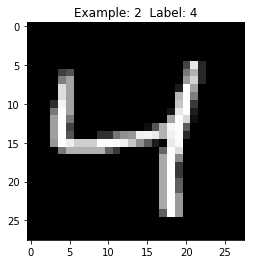

Image generated by RBM


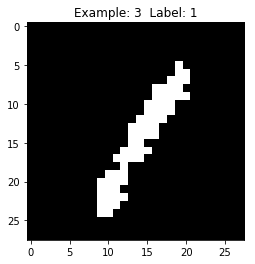

Original image


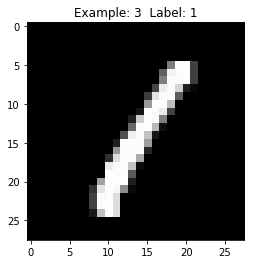

Image generated by RBM


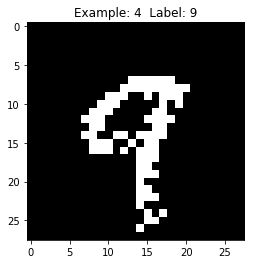

Original image


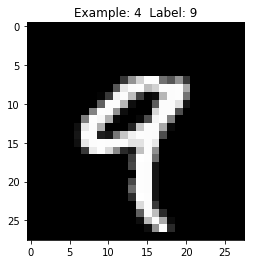

Image generated by RBM


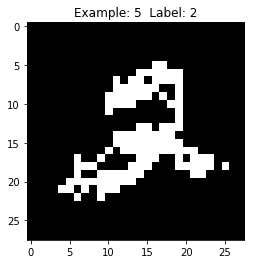

Original image


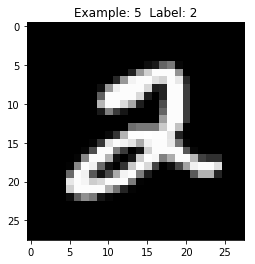

Image generated by RBM


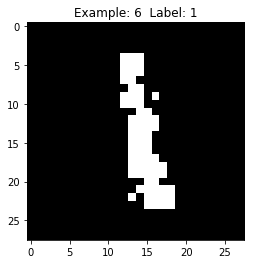

Original image


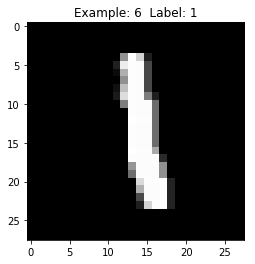

Image generated by RBM


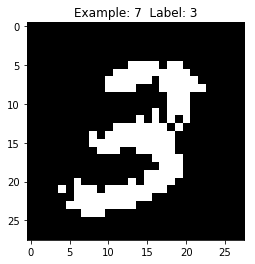

Original image


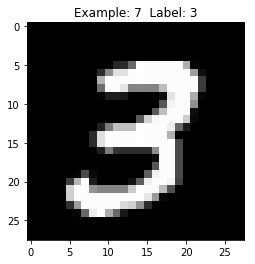

Image generated by RBM


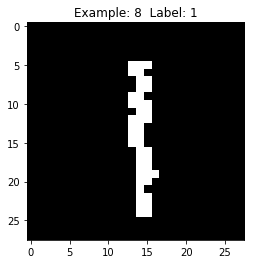

Original image


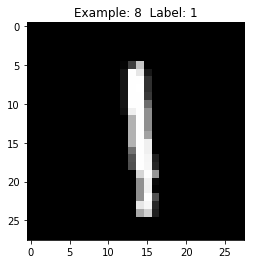

Image generated by RBM


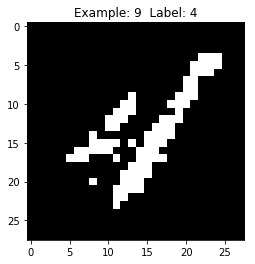

Original image


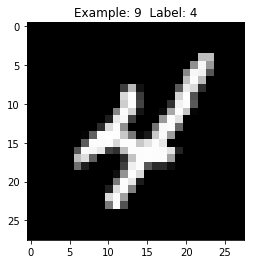

In [18]:
inputX = np.array(X_train)
rbmOne = rbm_list[0]

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, index=X_train.index)
for j in range(0,10):
    example = j
    print("Image generated by RBM")
    view_digit(reconstructedX_rbmOne, y_train, example)
    print("Original image")
    view_digit(X_train, y_train, example)

In [19]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # Define hyperparameters
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._original_input_size])
        #forwardOne = tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb)
        #forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)
        #forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)
        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb) 
                                        - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)
                                     - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)
                                     - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        #backwardOne = tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb)
        #backwardTwo = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb)
        #backward = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb)
        
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb) 
                           - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb) 
                           - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb)
                           - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb)))))
        
        err = tf.reduce_mean(tf.square(v0 - backward))
    
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
    def dbn_output(self, X):

        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [20]:
dbn = DBN(784, 500, 500, 1.0, 50, 200, rbm_list[0], rbm_list[1], rbm_list[2])

In [21]:
inputX = np.array(X_train)
dbn.train(inputX)

Epoch: 0 reconstruction error: 0.087908
Epoch: 1 reconstruction error: 0.079493
Epoch: 2 reconstruction error: 0.076089
Epoch: 3 reconstruction error: 0.074301
Epoch: 4 reconstruction error: 0.072722
Epoch: 5 reconstruction error: 0.071297
Epoch: 6 reconstruction error: 0.070429
Epoch: 7 reconstruction error: 0.069379
Epoch: 8 reconstruction error: 0.068731
Epoch: 9 reconstruction error: 0.068103
Epoch: 10 reconstruction error: 0.067568
Epoch: 11 reconstruction error: 0.066905
Epoch: 12 reconstruction error: 0.066757
Epoch: 13 reconstruction error: 0.066329
Epoch: 14 reconstruction error: 0.065831
Epoch: 15 reconstruction error: 0.065635
Epoch: 16 reconstruction error: 0.065070
Epoch: 17 reconstruction error: 0.064886
Epoch: 18 reconstruction error: 0.064703
Epoch: 19 reconstruction error: 0.064318
Epoch: 20 reconstruction error: 0.064251
Epoch: 21 reconstruction error: 0.064100
Epoch: 22 reconstruction error: 0.063812
Epoch: 23 reconstruction error: 0.063781
Epoch: 24 reconstruction e

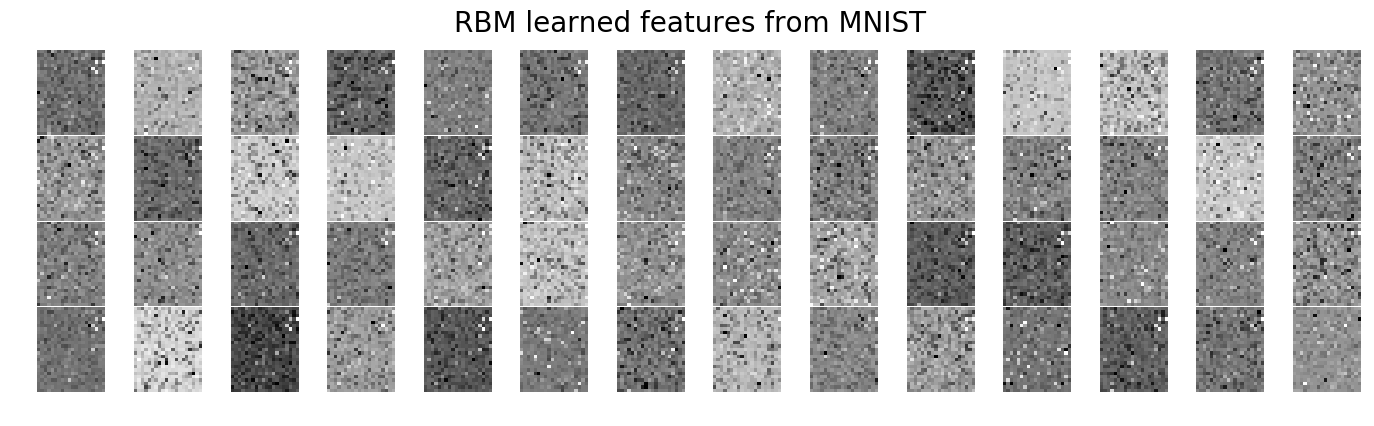

None


In [22]:
print(dbn.show_features((25,20),"RBM learned features from MNIST", 56))

In [55]:
inputXReduced = X_train
for i in range(0,20):
    print("Run ",i)
    finalOutput_DBN, reconstructedOutput_DBN = dbn.dbn_output(inputXReduced)
    if i==0:
        generatedImages = finalOutput_DBN
    else:
        generatedImages = np.append(generatedImages, finalOutput_DBN, axis=0)

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19


In [56]:
for i in range(0,20):
    if i==0:
        labels = y_train
    else:
        labels = np.append(labels,y_train)

In [38]:
inputXReduced = X_train.loc[:4999]
for i in range(0,20):
    print("Run ",i)
    finalOutput_DBN, reconstructedOutput_DBN = dbn.dbn_output(inputXReduced)
    if i==0:
        generatedImages = finalOutput_DBN
    else:
        generatedImages = np.append(generatedImages, finalOutput_DBN, axis=0)

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19
Run  20
Run  21
Run  22
Run  23
Run  24
Run  25
Run  26
Run  27
Run  28
Run  29
Run  30
Run  31
Run  32
Run  33
Run  34
Run  35
Run  36
Run  37
Run  38
Run  39
Run  40
Run  41
Run  42
Run  43
Run  44
Run  45
Run  46
Run  47
Run  48
Run  49


In [51]:
for i in range(0,20):
    if i==0:
        labels = y_train.loc[:4999]
    else:
        labels = np.append(labels,y_train.loc[:4999])

In [40]:
inputValidation = np.array(X_validation)
finalOutput_DBN_validation, reconstructedOutput_DBN_validation = dbn.dbn_output(inputValidation)

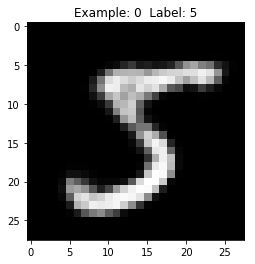

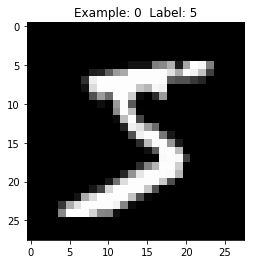

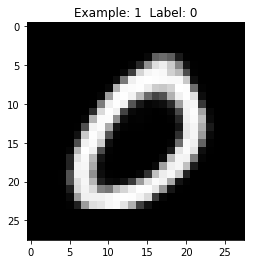

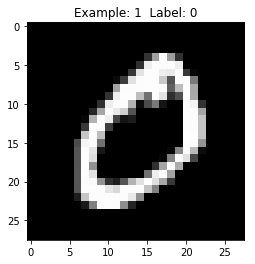

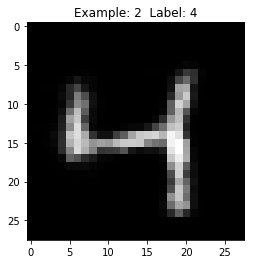

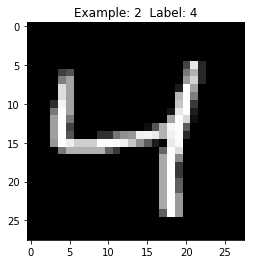

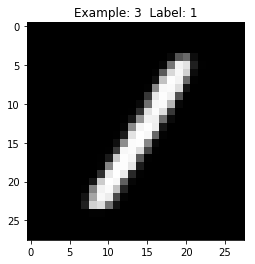

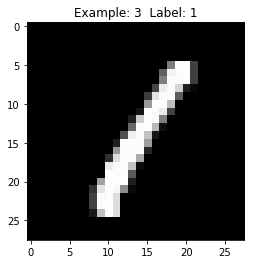

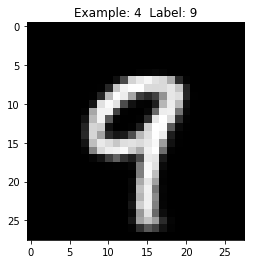

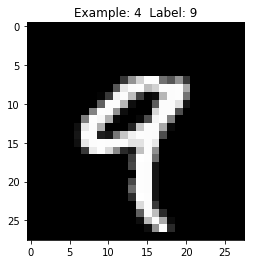

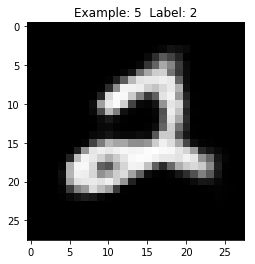

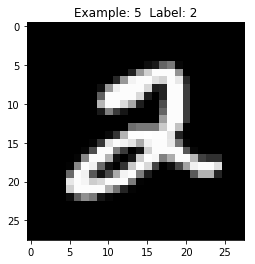

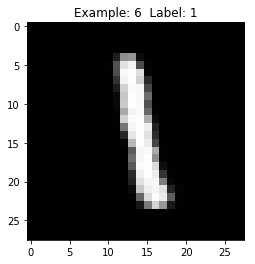

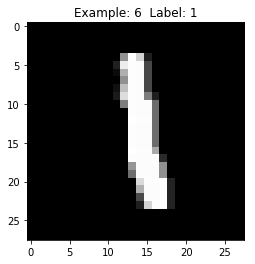

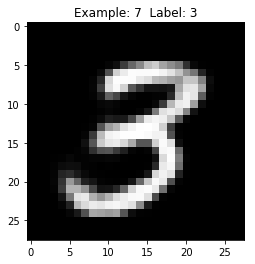

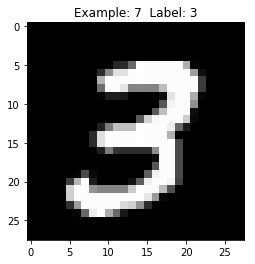

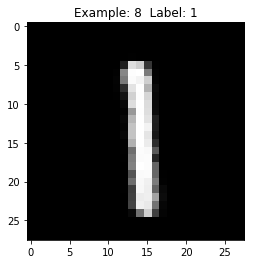

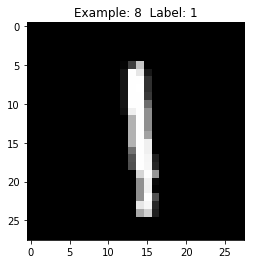

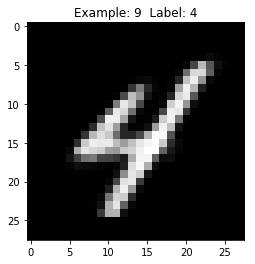

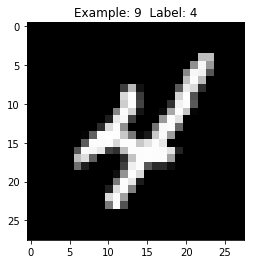

In [41]:
for i in range(0,10):
    example = i
    reconstructedX = pd.DataFrame(data=reconstructedOutput_DBN, index=X_train[0:5000].index)
    view_digit(reconstructedX, y_train, example)
    view_digit(X_train, y_train, example)

Run  0
Generated


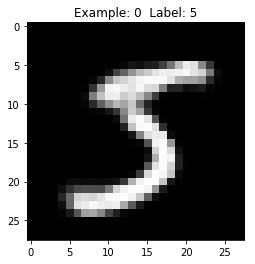

Run  1
Generated


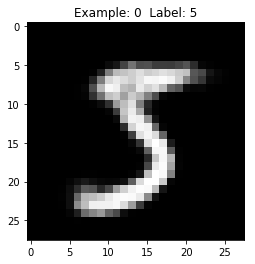

Run  2
Generated


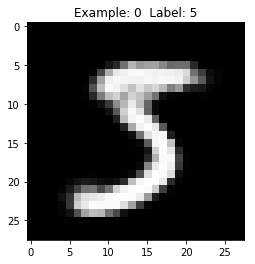

Run  3
Generated


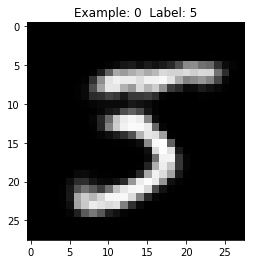

Run  4
Generated


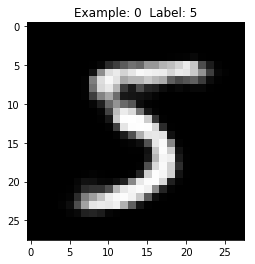

Run  5
Generated


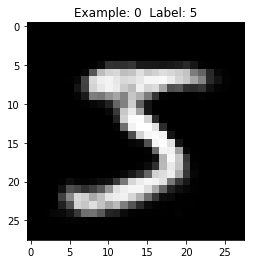

Run  6
Generated


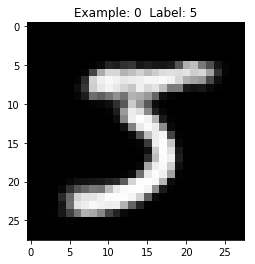

Run  7
Generated


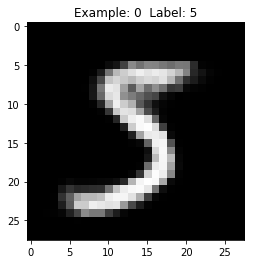

Run  8
Generated


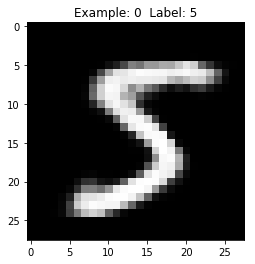

Run  9
Generated


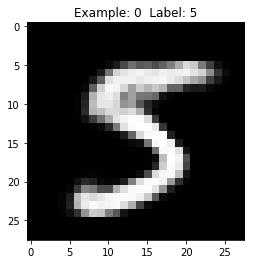

In [42]:
inputXReduced = X_train.loc[:0]
for i in range(0,10):
    example = 0
    print("Run ",i)
    finalOutput_DBN_fives, reconstructedOutput_DBN_fives = dbn.dbn_output(inputXReduced)
    reconstructedX_fives = pd.DataFrame(data=reconstructedOutput_DBN_fives,index=[0])
    print("Generated")
    view_digit(reconstructedX_fives, y_train.loc[:0], example)

In [43]:
predictionColumns = ['0','1','2','3','4','5','6','7','8','9']

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':10,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [44]:
trainingScore = []
validationScore = []
predictionsLightGBM = pd.DataFrame(data=[],index=y_validation.index,columns=predictionColumns)

lgb_train = lgb.Dataset(X_train.loc[:4999], y_train.loc[:4999])
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(y_train.loc[:4999], gbm.predict(X_train.loc[:4999], 
                            num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsLightGBM.loc[X_validation.index,predictionColumns] = gbm.predict(X_validation, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsLightGBM.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossLightGBM = log_loss(y_validation, predictionsLightGBM)
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBM)

[1]	valid_0's multi_logloss: 2.03259
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.83275
[3]	valid_0's multi_logloss: 1.6722
[4]	valid_0's multi_logloss: 1.54122
[5]	valid_0's multi_logloss: 1.4341
[6]	valid_0's multi_logloss: 1.33935
[7]	valid_0's multi_logloss: 1.25721
[8]	valid_0's multi_logloss: 1.18422
[9]	valid_0's multi_logloss: 1.11702
[10]	valid_0's multi_logloss: 1.05586
[11]	valid_0's multi_logloss: 0.99914
[12]	valid_0's multi_logloss: 0.947816
[13]	valid_0's multi_logloss: 0.90067
[14]	valid_0's multi_logloss: 0.858902
[15]	valid_0's multi_logloss: 0.819287
[16]	valid_0's multi_logloss: 0.784158
[17]	valid_0's multi_logloss: 0.752388
[18]	valid_0's multi_logloss: 0.722712
[19]	valid_0's multi_logloss: 0.695435
[20]	valid_0's multi_logloss: 0.669445
[21]	valid_0's multi_logloss: 0.645138
[22]	valid_0's multi_logloss: 0.621273
[23]	valid_0's multi_logloss: 0.600193
[24]	valid_0's multi_logloss: 0.580599
[25]	valid_0's multi_log

[208]	valid_0's multi_logloss: 0.191285
[209]	valid_0's multi_logloss: 0.191243
[210]	valid_0's multi_logloss: 0.19152
[211]	valid_0's multi_logloss: 0.191388
[212]	valid_0's multi_logloss: 0.191569
[213]	valid_0's multi_logloss: 0.191571
[214]	valid_0's multi_logloss: 0.191732
[215]	valid_0's multi_logloss: 0.191871
[216]	valid_0's multi_logloss: 0.191857
[217]	valid_0's multi_logloss: 0.191746
[218]	valid_0's multi_logloss: 0.191732
[219]	valid_0's multi_logloss: 0.191695
[220]	valid_0's multi_logloss: 0.191711
[221]	valid_0's multi_logloss: 0.19172
[222]	valid_0's multi_logloss: 0.191716
[223]	valid_0's multi_logloss: 0.191674
[224]	valid_0's multi_logloss: 0.191806
[225]	valid_0's multi_logloss: 0.191961
[226]	valid_0's multi_logloss: 0.192058
[227]	valid_0's multi_logloss: 0.192037
[228]	valid_0's multi_logloss: 0.191997
[229]	valid_0's multi_logloss: 0.191999
[230]	valid_0's multi_logloss: 0.191947
[231]	valid_0's multi_logloss: 0.192155
[232]	valid_0's multi_logloss: 0.192007
[2

In [45]:
predictionsLightGBM_firm = np.argmax(np.array(predictionsLightGBM), axis=1)
accuracyValidation_lightGBM = accuracy_score(np.array(y_validation), predictionsLightGBM_firm)
print("Supervised-Only Accuracy: ", accuracyValidation_lightGBM)

Supervised-Only Accuracy:  0.9439


In [52]:
# DBN
generatedImagesDF = pd.DataFrame(data=generatedImages,index=range(0,100000))
labelsDF = pd.DataFrame(data=labels,index=range(0,100000))

X_train_lgb = pd.DataFrame(data=generatedImagesDF,
                           index=generatedImagesDF.index)
X_validation_lgb = pd.DataFrame(data=finalOutput_DBN_validation,
                                index=X_validation.index)

In [53]:
trainingScore = []
validationScore = []
predictionsDBN = pd.DataFrame(data=[],index=y_validation.index,
                              columns=predictionColumns)

lgb_train = lgb.Dataset(X_train_lgb, labels)
lgb_eval = lgb.Dataset(X_validation_lgb, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=50)
    
loglossTraining = log_loss(labelsDF, gbm.predict(X_train_lgb, num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsDBN.loc[X_validation.index,predictionColumns] = gbm.predict(X_validation_lgb, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsDBN.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossDBN = log_loss(y_validation, predictionsDBN)
print('LightGBM Gradient Boosting Log Loss: ', loglossDBN)

[1]	valid_0's multi_logloss: 1.92197
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's multi_logloss: 1.67412
[3]	valid_0's multi_logloss: 1.49104
[4]	valid_0's multi_logloss: 1.34361
[5]	valid_0's multi_logloss: 1.21982
[6]	valid_0's multi_logloss: 1.11397
[7]	valid_0's multi_logloss: 1.02247
[8]	valid_0's multi_logloss: 0.943254
[9]	valid_0's multi_logloss: 0.87289
[10]	valid_0's multi_logloss: 0.809833
[11]	valid_0's multi_logloss: 0.753223
[12]	valid_0's multi_logloss: 0.703128
[13]	valid_0's multi_logloss: 0.658333
[14]	valid_0's multi_logloss: 0.618116
[15]	valid_0's multi_logloss: 0.581716
[16]	valid_0's multi_logloss: 0.548478
[17]	valid_0's multi_logloss: 0.518148
[18]	valid_0's multi_logloss: 0.490623
[19]	valid_0's multi_logloss: 0.465862
[20]	valid_0's multi_logloss: 0.443797
[21]	valid_0's multi_logloss: 0.423237
[22]	valid_0's multi_logloss: 0.40491
[23]	valid_0's multi_logloss: 0.38832
[24]	valid_0's multi_logloss: 0.37252
[25]	valid_0's multi_l

In [54]:
# DBN
predictionsDBN_firm = np.argmax(np.array(predictionsDBN), axis=1)
accuracyValidation_DBN = accuracy_score(np.array(y_validation), predictionsDBN_firm)
print(accuracyValidation_DBN)

0.9516
